# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

Number of reviews:   568,454
Number of users:     256,059
Number of products:  74,258
Timespan:            Oct 1999-Oct 2012
Number of Attributes:10

Attributes Information:

   1. Id
   2. ProductId - unique identifier for the product
   3. UserId - unique identifier for the user
   4. ProfileName
   5. HelpfulnessNumerator - no. of users who found review helpful
   6. HelpfulnessDenominator - total no. of users who found review helpful or not
   7. Score - rating between 1 and 5
   8. Time - timestamp for the review
   9. Summary - brief summary of the review
   10. Text - text of the review
   
   **Objective**- Review +ve or not?

In [3]:
%matplotlib inline

import sqlite3
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

In [4]:
#filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

#Give reviews with Score>3 a positive rating, and reviews with score<3 a negative rating
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

# changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [5]:
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [6]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserID="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [7]:
#Sorting data acc. to ProductID in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True)

In [8]:
#Deduplication fo entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
#keeping only those entries in which numerator<=Denominator  'CommonSense'
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


In [11]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Score
positive    307061
negative     57110
Name: count, dtype: int64

## Bag of Words (BoW)

In [12]:
#BoW
count_vect = CountVectorizer()  #in scikit-learn
final = final.sort_values(by='Time')
final_counts = count_vect.fit_transform(final['Text'].values)

In [13]:
type(final_counts)

scipy.sparse._csr.csr_matrix

In [14]:
final_counts.get_shape()

(364171, 115281)

# Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [17]:
final['Score'] = final['Score'].replace({'positive': 1, 'negative': 0})
final_num = final.select_dtypes(include=['number'])
X = final_num.drop(['Score'], axis=1)
y = final_num['Score']

In [18]:
# Define the parameter grid for the decision tree depth
param_grid = {'max_depth': range(1, 11)}  # Testing depths from 1 to 10

# Initialize the decision tree classifier
dt = DecisionTreeClassifier()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best estimator
best_dt = grid_search.best_estimator_

# Get the best depth
best_depth = grid_search.best_params_['max_depth']

# Print the best depth and corresponding accuracy
print("Best Depth:", best_depth)
print("Best Accuracy:", grid_search.best_score_)

Best Depth: 1
Best Accuracy: 0.8431780674416072


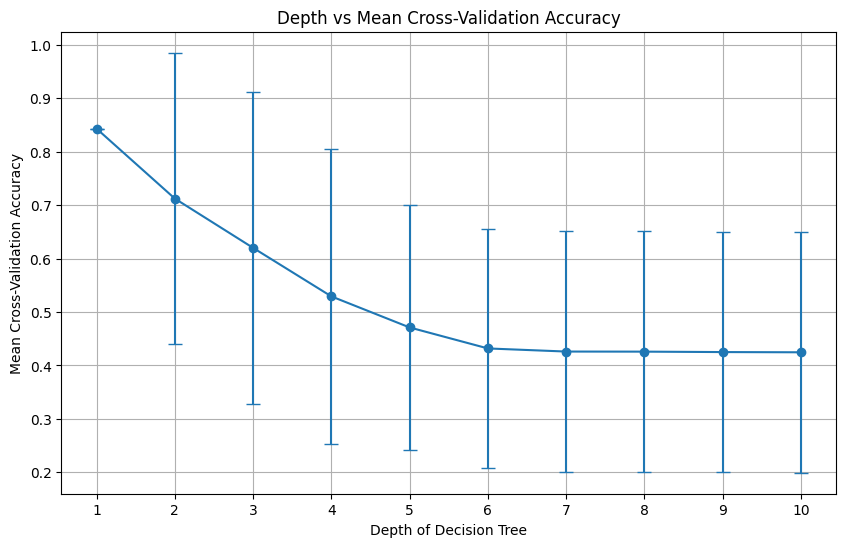

In [19]:
# Get the cross-validation results from the grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores and standard deviations for each depth
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Get the depths tested
depths = param_grid['max_depth']

# Plot the graph
plt.figure(figsize=(10, 6))
plt.errorbar(depths, mean_test_scores, yerr=std_test_scores, fmt='-o', capsize=5)
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Depth vs Mean Cross-Validation Accuracy')
plt.grid(True)
plt.xticks(depths)
plt.show()

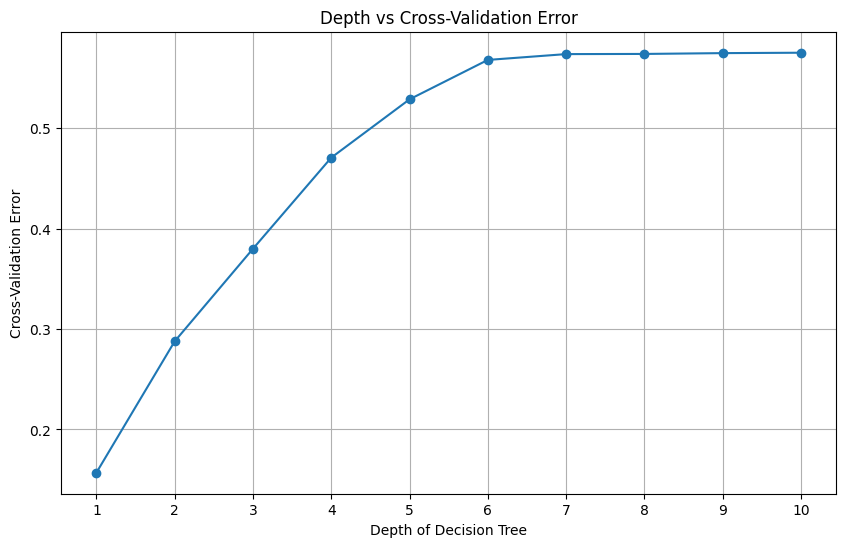

In [20]:
# Get the cross-validation results from the grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each depth
mean_test_scores = cv_results['mean_test_score']

# Calculate the cross-validation error (1 - accuracy)
cv_errors = 1 - mean_test_scores

# Get the depths tested
depths = param_grid['max_depth']

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(depths, cv_errors, marker='o')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Cross-Validation Error')
plt.title('Depth vs Cross-Validation Error')
plt.grid(True)
plt.xticks(depths)
plt.show()

# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Create a random forest classifier
rf_classifier = RandomForestClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Generate synthetic dataset (replace with your own data)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Perform grid search
grid_search.fit(X, y)

# Get the best hyperparameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy Score: 0.9019999999999999


We got **accuracy** of 90.10%

# Gradient Boosting Decision Tree

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Create a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search object
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Generate synthetic dataset (replace with your own data)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Perform grid search
grid_search.fit(X, y)

# Get the best hyperparameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Accuracy Score: 0.9129999999999999


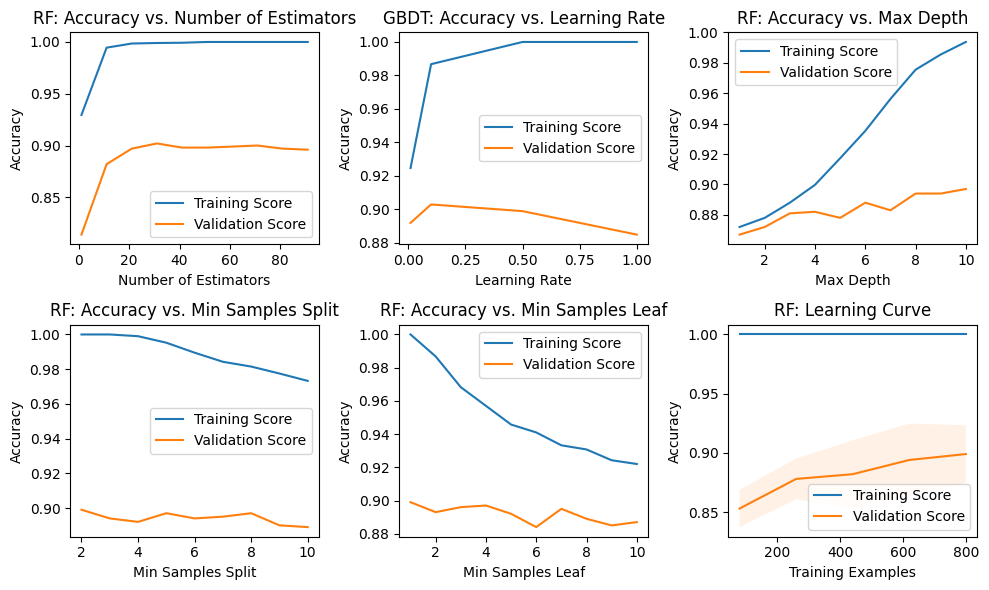

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Gradient Boosted Decision Trees (GBDT)
gbdt_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Define hyperparameter ranges
param_range = np.arange(1, 101, 10)  # Example range for number of estimators

# Plot 1: Accuracy vs. Number of Estimators
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
train_scores, test_scores = validation_curve(rf_clf, X, y, param_name="n_estimators", param_range=param_range, cv=5)
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('RF: Accuracy vs. Number of Estimators')
plt.legend()

# Plot 2: Accuracy vs. Learning Rate
plt.subplot(2, 3, 2)
param_range = [0.01, 0.1, 0.5, 1.0]  # Example range for learning rate
train_scores, test_scores = validation_curve(gbdt_clf, X, y, param_name="learning_rate", param_range=param_range, cv=5)
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('GBDT: Accuracy vs. Learning Rate')
plt.legend()

# Plot 3: Accuracy vs. Max Depth
plt.subplot(2, 3, 3)
param_range = np.arange(1, 11)  # Example range for max depth
train_scores, test_scores = validation_curve(rf_clf, X, y, param_name="max_depth", param_range=param_range, cv=5)
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('RF: Accuracy vs. Max Depth')
plt.legend()

# Plot 4: Accuracy vs. Min Samples Split
plt.subplot(2, 3, 4)
param_range = np.arange(2, 11)  # Example range for min samples split
train_scores, test_scores = validation_curve(rf_clf, X, y, param_name="min_samples_split", param_range=param_range, cv=5)
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('RF: Accuracy vs. Min Samples Split')
plt.legend()

# Plot 5: Accuracy vs. Min Samples Leaf
plt.subplot(2, 3, 5)
param_range = np.arange(1, 11)  # Example range for min samples leaf
train_scores, test_scores = validation_curve(rf_clf, X, y, param_name="min_samples_leaf", param_range=param_range, cv=5)
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('RF: Accuracy vs. Min Samples Leaf')
plt.legend()

# Plot 6: Learning Curve
plt.subplot(2, 3, 6)
train_sizes, train_scores, test_scores = learning_curve(rf_clf, X, y, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, test_scores_mean, label='Validation Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('RF: Learning Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
final['Score'] = final['Score'].replace({1:'positive', 0:'negative'})

## Text Preprocessing: Stemming, stop-word removal and Lemmatization

In [25]:
#find sentences containing HTML tags
import re
#Tutorial about Python regular expressions: https://pymotw.com/2/re/

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [26]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) # set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('*************************************')
print(sno.stem('tasty'))

{'about', 'haven', 'as', 'doing', 'ain', 'its', "should've", 'doesn', 'her', 'why', 'wouldn', 'between', "shan't", 'needn', 'other', 'until', 'weren', 'the', 'having', "wouldn't", 'too', 'won', 'what', 'in', 'again', 'from', 'do', 'here', "mightn't", 'out', 'those', 'm', 'of', 'against', 'below', "you're", 'while', 'me', "weren't", 'is', 'by', 've', 'we', 'mightn', 'very', 'an', 'some', 'because', 'she', 'o', 'at', 'wasn', 'same', 'them', 'they', 'aren', 'off', 'your', 'themselves', "couldn't", "hasn't", 'further', 'with', 'most', 'myself', 'through', 'hers', 'each', 'both', 're', 'all', 'ours', 'has', 'over', 'there', 'or', 'down', 'yours', 'only', 'don', "you'll", 'during', 'were', 's', 'yourself', "you've", "it's", 'couldn', 'herself', 'and', 'should', "mustn't", 'when', 'can', 'these', "shouldn't", 'isn', 'ma', 'yourselves', 'for', 'does', 'not', "doesn't", 'shouldn', 'but', 'if', 'before', 'i', 'into', 'this', 'shan', 'll', 'that', 'are', 'did', 'mustn', 'than', 'be', "haven't", "

In [27]:
#This code takes a while to run as it needs to run on 500k sentences
i=0
strl=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue
                
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
                        

In [28]:
final['CleanedText']=final_string #adding a coln of CleanendText

In [29]:
final.head(3)

#store final table into SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace')

364171

## Bi-Grams and n-Grams

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

In [30]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most common positive words : ",freq_dist_positive.most_common(20))
print("Most common negative words : ",freq_dist_negative.most_common(20))

Most common positive words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most common negative words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


## TF_IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)

In [32]:
final_tf_idf.get_shape()

(364171, 2910192)

In [33]:
features = tf_idf_vect.get_feature_names_out()
len(features)

2910192

In [34]:
features[100000:100010]

array(['ales until', 'ales ve', 'ales would', 'ales you', 'alessandra',
       'alessandra ambrosia', 'alessi', 'alessi added', 'alessi also',
       'alessi and'], dtype=object)

In [35]:
# convert a row in sparsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [36]:
# source: https://buhrmann.github.io/tfidf-analysis.html
import numpy as np
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [37]:
top_tfidf

,feature,tfidf
0,amp,0.288840
1,books,0.156924
2,sister later,0.131495
3,the lp,0.131495
4,songs when,0.131495
5,books amp,0.131495
6,amp turned,0.131495
7,day thirty,0.131495
8,lp which,0.131495
9,preschoolers amp,0.131495


# Word2Vec

In [53]:
list_of_sent = []
for sent in final['Text'].values:
    filtered_sentence = []
    # Perform text cleaning here
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_word in cleanpunc(w).split():
            if cleaned_word.isalpha():  # Corrected variable name
                filtered_sentence.append(cleaned_word.lower())  # Corrected variable name
    list_of_sent.append(filtered_sentence)

In [54]:
print(final['Text'].values[0])
print("**********************************************************")
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
**********************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in',

In [2]:
%pip install gensim==3.4.0
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent, min_count=5, workers=4)
# Get the dimensions of word vectors
vector_size = w2v_model.vector_size
print(f"Word vector dimensions: {vector_size}")


ImportError: cannot import name 'Mapping' from 'collections' (/opt/homebrew/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/collections/__init__.py)

In [1]:
words = list(w2v_model.wv.key_to_index)
print(len(words))

NameError: name 'w2v_model' is not defined

In [ ]:
similar_words = w2v_model.wv.most_similar('tasty')
print(similar_words)

In [ ]:
similar_words = w2v_model.wv.most_similar('like')
print(similar_words)

In [ ]:
import numpy as np

# Assuming count_vect_feat is a numpy array
count_vect_feat = count_vect.get_feature_names_out()  # list of words in BoW
index_of_like = np.where(count_vect_feat == 'like')[0][0]  # Get the first index where 'like' occurs
print(index_of_like)

# Avg W2V, TFIDF-W2V

In [ ]:
#compute average Word2Vec for each review
sent_vectors =[];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0;
    for word in  sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

        

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names_out()

tfidf_sent_vectors = []
row = 0

for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weighted_sum = 0
    
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weighted_sum += tfidf
        except:
            pass
    
    sent_vec /= weighted_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


## Naive Bayes Assignment

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

X = final_counts[0:10000,:]
y = final['Score'][0:10000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict labels for the test data
y_pred = clf.predict(X_test)

In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Create a Naive Bayes classifier
nb_classifier = MultinomialNB()

# Define a range of alpha values to search
alpha_range = np.arange(0.1, 1.1, 0.1)  # Adjust the range as needed

# Create a parameter grid
param_grid = {'alpha': alpha_range}

# Perform grid search using 10-fold cross-validation
grid_search = GridSearchCV(nb_classifier, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Train the Naive Bayes classifier with the best alpha value
clf_best_alpha = MultinomialNB(alpha=best_alpha)
clf_best_alpha.fit(X_train, y_train)

# Predict labels for the test data
y_pred_best_alpha = clf_best_alpha.predict(X_test)

# Evaluate the classifier with the best alpha value
accuracy_best_alpha = accuracy_score(y_test, y_pred_best_alpha)
print("Accuracy with best alpha:", accuracy_best_alpha)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3', '4', '5'], 
            yticklabels=['1', '2', '3', '4', '5'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# T-SNE

## t-SNE for BoW

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = final_counts[0:1000,:]
labels_1000 = final['Score'][0:1000]

model = TSNE(n_components=2, random_state=0, init='random')
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iteration for the optimization = 1000

tsne_data = model.fit_transform(data_1000)

#creating a new dataFrame which help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T 
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Set a consistent size for all points and adjust the point color
scatter_kws = {'s': 50, 'edgecolors': 'k', 'linewidth': 0.5}
palette = sns.color_palette("viridis", as_cmap=True)

#plotting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2', **scatter_kws).add_legend()
plt.show()

## t-SNE for TF-IDF

In [ ]:
# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = final_tf_idf[0:1000,:]
labels_1000 = final['Score'][0:1000]

model = TSNE(n_components=2, random_state=0, init='random')
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iteration for the optimization = 1000

tsne_data = model.fit_transform(data_1000)

#creating a new dataFrame which help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T 
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Set a consistent size for all points and adjust the point color
scatter_kws = {'s': 50, 'edgecolors': 'k', 'linewidth': 0.5}
palette = sns.color_palette("viridis", as_cmap=True)

#plotting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2', **scatter_kws).add_legend()
plt.show()

## Applying KNN

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn import datasets, neighbors 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

def knn_comparison(data, n_neighbors=15):
    x = data[:, :2]
    y = data[:, 2]

    # Create a label encoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Create and fit the k-NN classifier
    clf = KNeighborsClassifier(n_neighbors)
    clf.fit(x, y_encoded)

    # Define the range of the plot
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

    # Generate meshgrid for the decision boundary
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict the labels for each point in the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Reshape the predicted labels array to the shape of the meshgrid
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot data points
    plt.scatter(x[:, 0], x[:, 1], c=y_encoded, cmap=plt.cm.Paired)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"K-NN Classification (k={n_neighbors})")
    plt.show()

### KNN for BoW

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = final_counts[0:5000,:]
labels_1000 = final['Score'][0:5000]

model = TSNE(n_components=2, random_state=0, init='random')
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iteration for the optimization = 1000

tsne_data = model.fit_transform(data_1000)

#creating a new dataFrame which help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T 
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

In [ ]:
# Assuming your DataFrame is named tsne_df
tsne_df['Score'] = tsne_df['Score'].map({'positive': 1, 'negative': 0})
tsne_df.head()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [ ]:
names = ['x', 'y', 'class']

df = tsne_df.copy()  # Make a copy of tsne_df
df.columns = names   # Assign new column names

print(df.head())

# create design matrix x and target vector y
x = np.array(df.iloc[:, 0:2])  # Assuming 'x' and 'y' are the first two columns
y = np.array(df['class'])

In [ ]:
# split the data set into train & test
x_1, x_test, y_1, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state = 42)

# split the data set into cross validation train & cross validation test
x_tr, x_cv, y_tr, y_cv = model_selection.train_test_split(x_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(x_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(x_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize = True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))

knn = KNeighborsClassifier(1)
knn.fit(x_tr, y_tr)
pred = knn.predict(x_test)
acc = accuracy_score(y_test, pred, normalize = True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))

In [ ]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10 fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

#plot misclassification error vs k
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE, 3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE, 3))


In [ ]:
# KNN with k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

knn_optimal.fit(x_tr, y_tr)
pred = knn_optimal.predict(x_test)

#evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

### KNN for tf-idf

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = final_counts[0:5000,:]
labels_1000 = final['Score'][0:5000]

model = TSNE(n_components=2, random_state=0, init='random')
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iteration for the optimization = 1000

tsne_data = model.fit_transform(data_1000)

#creating a new dataFrame which help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T 
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

In [ ]:
# Assuming your DataFrame is named tsne_df
tsne_df['Score'] = tsne_df['Score'].map({'positive': 1, 'negative': 0})
tsne_df.tail()

In [ ]:
names = ['x', 'y', 'class']

df = tsne_df.copy()  # Make a copy of tsne_df
df.columns = names   # Assign new column names

print(df.head())

# create design matrix x and target vector y
x = np.array(df.iloc[:, 0:2])  # Assuming 'x' and 'y' are the first two columns
y = np.array(df['class'])

In [ ]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10 fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

#plot misclassification error vs k
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE, 3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE, 3))


In [ ]:
# KNN with k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

knn_optimal.fit(x_tr, y_tr)
pred = knn_optimal.predict(x_test)

#evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# Applying Logistic Regression 

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
X = final_counts[0:10000,:]
y = final['Score'][0:10000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

In [ ]:
# Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring='accuracy', cv=5)
model.fit(X_train, y_train)

# Print the best estimator and its accuracy on the test set
print("Best Estimator:", model.best_estimator_)
print("Accuracy on Test Set:", model.score(X_test, y_test))

In [ ]:
#More Sparsity
import numpy as  np

clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

In [ ]:
clf = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

In [ ]:
clf = LogisticRegression(C=0.001, penalty='l1', solver='liblinear')
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

In [ ]:
clf = LogisticRegression(C=10, penalty='l1', solver='liblinear')
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {'C': np.logspace(-4, 4, 20)}

# Initialize Logistic Regression classifier
clf = LogisticRegression()

# Initialize RandomizedSearchCV
model = RandomizedSearchCV(clf, param_distributions, scoring='accuracy', cv=5, n_iter=10, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Print the best estimator found by RandomizedSearchCV
print("Best Estimator:", model.best_estimator_)

# Print the Accuracy score of the best estimator on the test data
print("Accuracy on Test Data:", model.score(X_test, y_test))

In [ ]:
print("Accuracy on Test Data:", model.score(X_test, y_test))

# SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameters for SVM
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# Apply GridSearchCV with SVM
svm_model = GridSearchCV(SVC(), tuned_parameters, scoring='accuracy', cv=5)
svm_model.fit(X_train, y_train)

# Print the best estimator and its accuracy on the test set
print("Best Estimator:", svm_model.best_estimator_)
print("Accuracy on Test Set:", svm_model.score(X_test, y_test))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {'C': np.logspace(-4, 4, 20), 'gamma': np.logspace(-4, 4, 20)}

# Initialize SVM classifier
svm_clf = SVC()

# Initialize RandomizedSearchCV
svm_model = RandomizedSearchCV(svm_clf, param_distributions, scoring='accuracy', cv=5, n_iter=10, random_state=42)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Print the best estimator found by RandomizedSearchCV
print("Best Estimator:", svm_model.best_estimator_)

# Print the Accuracy score of the best estimator on the test data
print("Accuracy on Test Data:", svm_model.score(X_test, y_test))